#Objetivos
O objetivo deste notebook é mostrar a aplicação do modelo de detecção de placas, como detecção de caracteres específicos de cada placa e inferências em imagem fora do dataset e em vídeos.

Neste notebook é usado o modelo treinado anteriormente de identificação de placas para assim uma outra rede neural pré treinada (OCR) identifique os caracteres. Códigos adaptados de [1].

In [ ]:
pip install easyocr

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.0/874.0 kB 14.4 MB/s eta 0:00:00


In [ ]:
# Carregando modelo OCR
import cv2
import easyocr
import matplotlib.pyplot as plt

# Rodar apenas uma vez
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.10/dist-packages/easyocr/detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_model, ma


0: 416x800 2 Plates, 487.5ms
Speed: 3.4ms preprocess, 487.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 800)


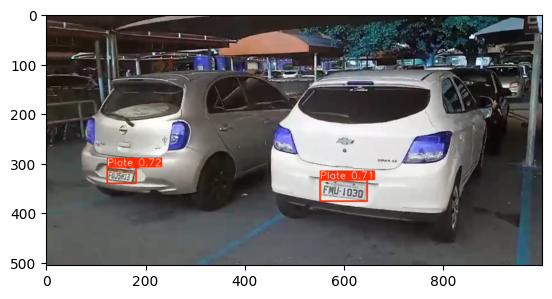

In [206]:
# Carregando modelo_v2
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Carregar o modelo YOLOv8 pré-treinado
model_path = '/content/drive/MyDrive/runs/detect/train2/weights/best.pt'
model = YOLO(model_path)

# Carregando imagem de inferência
image_url = '/content/drive/MyDrive/runs/imagem_teste.png'
image = cv2.imread(image_url)
results_plate = model(image)

# Plotar a imagem com os bounding boxes
plt.imshow(results_plate[0].plot(show=False))
plt.show()

In [188]:
# Imprimir coordenadas no formato COCO i.e. (Xmin, Ymin, Xmax, Ymax)
results_plate[0].boxes.xyxy

tensor([[756.6891, 232.6252, 936.2643, 294.5325],
        [202.4609, 188.5458, 270.1077, 217.0739]])

In [189]:
# Adquirindo lista de coordenadas de cada box de detecção
num_of_boxes = len(results_plate[0].boxes.xyxy) # Número de detecções
boxes_coords = [] # Coordenadas das detecções
for i in range(num_of_boxes):
  boxes_coords.append(results_plate[0].boxes.xyxy[i].tolist())

In [190]:
# Cortando imagens e extraindo caracteres alphanuméricos
def plate_strings(image, boxes_coords):
  """ Esta função usa do modelo de detecção de placas YOLO para filtrar regiões na imagem para o modelo OCR detectar caracteres nas placas detectadas
      Input: imagem, coordenadas das detecções
      Output: lista com coordenadas e strings detectadas das placas, lista com as coordenadas dos boxes
  """
  # Número de detecções
  num_of_boxes = len(boxes_coords)
  # Coordenadas dos boxes detectados por YOLO
  x1 = []
  x2 = []
  y1 = []
  y2 = []
  for i in range(num_of_boxes):
    x1.append(int(boxes_coords[i][0]))
    y1.append(int(boxes_coords[i][1]))
    x2.append(int(boxes_coords[i][2]))
    y2.append(int(boxes_coords[i][3]))

  # Cortar as imagens
  cropped_images = []
  for i in range(num_of_boxes):
    cropped_image = image[y1[i]:y2[i], x1[i]:x2[i]]
    cropped_images.append(cropped_image)

  # Executar o OCR nas imagens cortadas
  _results_char = []
  for i in range(num_of_boxes):
    _results_char.append(reader.readtext(cropped_images[i]))

  return _results_char,x1,y1,x2,y2

In [191]:
# Testando função
results_char, X1, Y1, X2, Y2 = plate_strings(image, boxes_coords)
results_char[0][0]

([[9, 19], [175, 19], [175, 59], [9, 59]], 'AFR: 1859', 0.363859429525165)

##Plotando OCR com modelo_v2

In [202]:
def plotar_identific_placas(image,results_ocr,results_yolo, X1_, Y2_):
  """Input: imagem, resultados_ocr, resultados_yolo
     Output: imagem com identificação de placas e respectivos caracteres com respectivas acurácias
  """
  # Plotando imagem com identificação de placas e respectivos caracteres
  plt.imshow(image)
  # Listas de coordenadas de textos
  X_text_coords = []
  Y_text_coords = []
  text_strings = []
  size = len(results_ocr)
  for i in range(size):
    for res in results_ocr[i]:
      # Coordenadas de boxes detectados dos caracteres
      xy = res[0]
      xy1, xy2, xy3, xy4 = xy[0], xy[1], xy[2], xy[3]
      # Texto e acurácia
      det, conf = res[1], res[2]
      # Adicionando à listas de texto e coordenadas
      X_text_coords.append(xy1[0] + X1_[i])
      Y_text_coords.append(xy1[1] + Y2_[i])
      text_strings.append(f'{det}  {round(conf, 2)}')
  # Plotando imagens com identificações
  for i in range(size):
    plt.text(X_text_coords[i], Y_text_coords[i], text_strings[i], fontsize=5, bbox=dict(facecolor='red', edgecolor='none',alpha=0.7), color ='white')
  plt.imshow(results_yolo[0].plot(show=False))
  plt.show()

#Testando com imagens variadas

In [203]:
# Juntando todos os paços em uma só função para automatizar o processo
def identific_placa(img_url):
  """ Esta função usa do modelo de detecção de placas YOLO para filtrar regiões na imagem para o modelo OCR detectar caracteres nas placas detectadas
      Input: imagem
      Output: imagem com identificação de placas e respectivos caracteres com respectivas acurácias
  """
  _image = cv2.imread(img_url)
  _results_plate = model(_image)
  # Adquirindo lista de coordenadas de cada box de detecção
  _num_of_boxes = len(_results_plate[0].boxes.xyxy) # Número de detecções
  _boxes_coords = [] # Coordenadas das detecções
  for i in range(_num_of_boxes):
    _boxes_coords.append(_results_plate[0].boxes.xyxy[i].tolist())
  _results_char, _X1, _, _, _Y2 = plate_strings(_image, _boxes_coords)
  plotar_identific_placas(_image,_results_char,_results_plate, _X1, _Y2)


0: 416x800 2 Plates, 505.6ms
Speed: 4.6ms preprocess, 505.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 800)


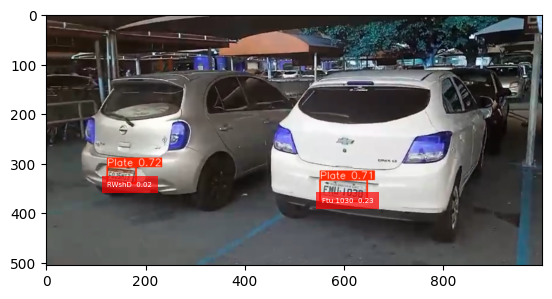


0: 416x800 2 Plates, 527.8ms
Speed: 4.7ms preprocess, 527.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 800)


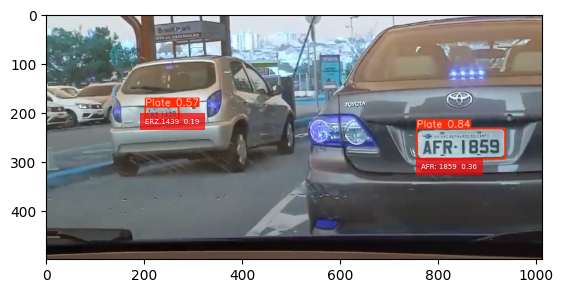


0: 416x800 (no detections), 509.9ms
Speed: 4.9ms preprocess, 509.9ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 800)


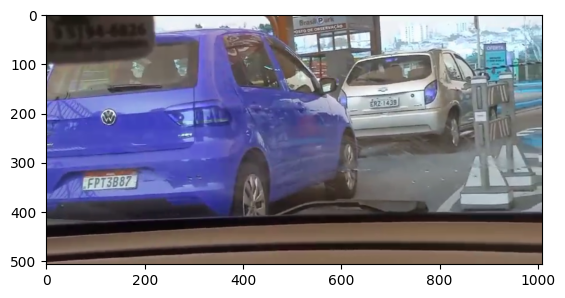


0: 416x800 2 Plates, 511.5ms
Speed: 6.9ms preprocess, 511.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 800)


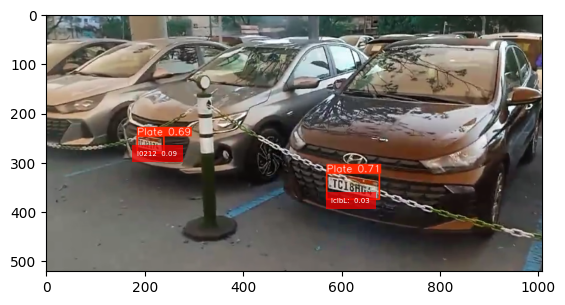

In [205]:
identific_placa('/content/drive/MyDrive/runs/imagem_teste.png')
identific_placa('/content/drive/MyDrive/runs/imagem2.png')
identific_placa('/content/drive/MyDrive/runs/imagem3.png')
identific_placa('/content/drive/MyDrive/runs/imagem4.png')

#Discussão
A identificação de caracteres com a detecção é possível, entretanto acredita-se por hipótese que o modelo OCR geral pode obter um grau maior de *confidence* com um dataset próprio de caracteres no contexto de placas de carro. O melhor resultado foi na segunda imagem plotada na seção "testando com imagens variadas", em que mostra uma *confidence* de 0.36.

#Referências
[1] HASAN, M. OCR with Deep Learning in Python. 2024. Disponível em: https://eng-mhasan.medium.com/ocr-with-deep-learning-in-python-e443970d09e4. Acesso em: 20 set. 2024.